# FORECASTING TIME SERIES
## PROMOTION AND COMPETITON EFFECTS ON SPANISH MILK MANUFACTURING

This work is part of my final project at the IE School of Human Sciences and Technology, the data has been provided by a large global market research company. In this work it will be assesed, how revenues of a specific Spanish milk manufacturer will behave and the analysis distinguishes between two distribution channels: Hyper- and Supermarkets. 
The modeled scenarios includes prodcuts that are discounted versus products that are not discounted with different levels of competition. For each scenatio revenues have been projected for the next 6 months using the SARIMAX methodology. 

_Special thanks to Javier Galvis Moreno who enriched the data with extensive feature engineering and Nina Gorbenko for the useful hints in time series modeling._

In [1]:
#Basic Libararies
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

#TIME SERIES
import statsmodels.api as sm
import statsmodels.tsa.api as smt 
#Imporing the api imports

#MATPLOTLIB
from scipy import stats, integrate
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
milk = pd.read_csv('/Users/natasha/Desktop/Term_3/Datathon/Milk_Data/sales_full_final.csv')
milk_weekly = milk.groupby('cod_semana').mean() #aggregte data

Now we will split the data into the two distribution channels:
- Hypermarket
- Supermarket

We will start with Hypermarkets.

## HYPERMARKET

In [3]:
#NO PROMOTIONS
milk2_mhnp = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 (milk['dummy_channel_hypermarket']==1) & (milk['dummy_Promo_descuento']!=1)]

no_promo_hyper = milk2_mhnp.groupby('cod_semana').mean()

In [4]:
#PROMOTIONS
milk2_mhp = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 (milk['dummy_channel_hypermarket']==1) & (milk['dummy_Promo_descuento']==1)]
promo_hyper = milk2_mhp.groupby('cod_semana').mean()

In [5]:
#SANITY CHECK
print('All Data Product Discounts', milk.dummy_Promo_descuento.mean())
print('Hyper Promo', promo_hyper.dummy_Promo_descuento.mean())
print('Hyper No Promo', no_promo_hyper.dummy_Promo_descuento.mean())

All Data Product Discounts 0.18276050526189655
Hyper Promo 1.0
Hyper No Promo 0.0


Another split follows for products that are discounted versus products that are not on discount.

### NO PROMO
#### STEPWISE REGRESSION

Determine the most important features that are potential candidates for our Time Series Model.

In [11]:
import statsmodels.api as sm


X = no_promo_hyper.drop(['ventas_valor'], axis=1)
y = no_promo_hyper.ventas_valor


def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01,  #set lower bound confidence interval (CI)
                       threshold_out = 0.05, #upper bound CI
                       verbose=True):
    
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print('All significant variables:', result)

Add  sales_value_by_sqmeter         with p-value 6.51134e-91
Add  sales_surface_sqmeters         with p-value 8.76468e-15
Add  addtv_present_CALCIUM          with p-value 2.29138e-16
Add  addtv_present_CEREALS          with p-value 2.29138e-16
Add  sgmnt_present_KIDS_>_3_YEARS_OLD with p-value 2.29138e-16
Add  brnd_present_MAN_2_BRAND_1     with p-value 2.29138e-16
Add  dummy_MANUFACTURER_2           with p-value 2.29138e-16
Add  sgmnt_present_KIDS_<=_3_YEARS_OLD with p-value 2.29138e-16
Add  manuf_present_MANUFACTURER_2   with p-value 2.29138e-16
Add  dummy_channel_hypermarket      with p-value 2.29138e-16
Add  variety_present_3_YEARS_OLD    with p-value 2.29138e-16
Add  brnd_present_OTH_MAN_BRAND_8   with p-value 0.00651852
Add  brnd_present_OTH_MAN_BRAND_10  with p-value 0.000349612
resulting features:
All significant variables: ['sales_value_by_sqmeter', 'sales_surface_sqmeters', 'addtv_present_CALCIUM', 'addtv_present_CEREALS', 'sgmnt_present_KIDS_>_3_YEARS_OLD', 'brnd_present_MAN

## Stationarity

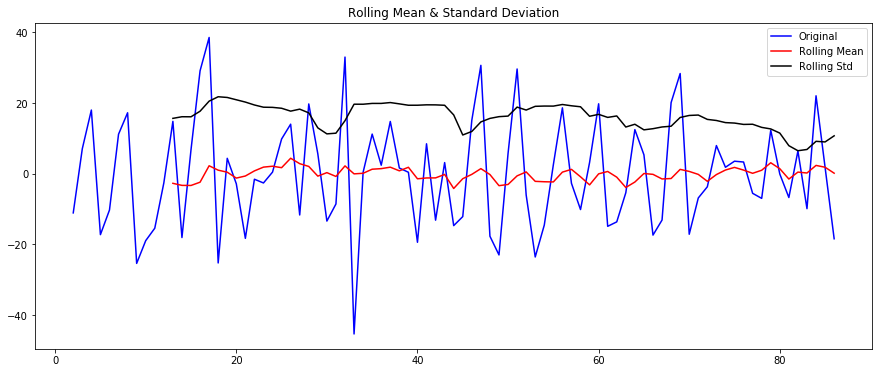

Results of Dickey-Fuller Test:
Test Statistic                 -4.928676
p-value                         0.000031
#Lags Used                      9.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


In [12]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller

z = y.diff() #take one difference from the timeseries 
z.dropna(inplace=True)

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)#On transformed data
test_stationarity(z) #one transformation is enough

## Orignial Scale ACF PACF

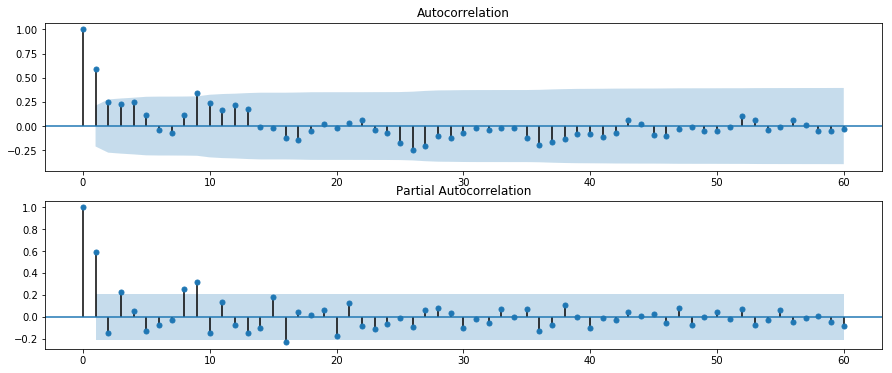

In [13]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=60, ax=ax2)
plt.show()

## Differenced ACF, PACF

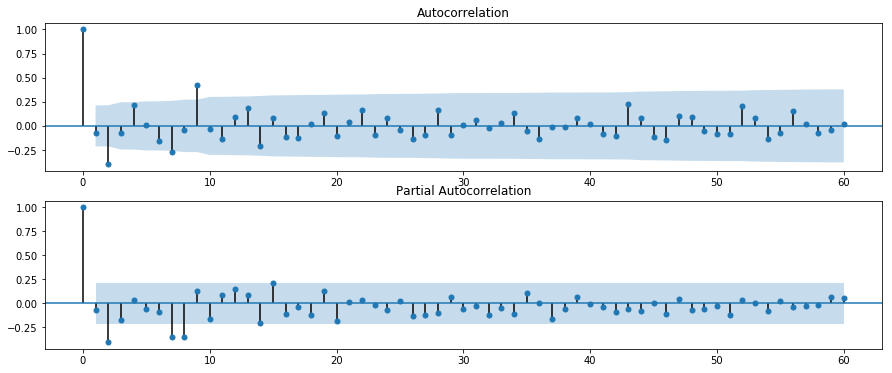

In [14]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(z, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(z, lags=60, ax=ax2)
plt.show()

## Seasonal ACF, PACF

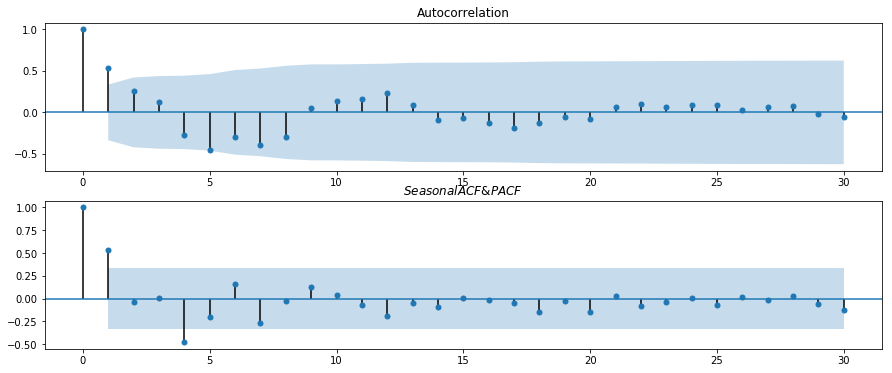

In [15]:
#TAKE THE SEASONAL DIFFERENCE
from matplotlib import pyplot

X = y.values
diff = list()
weeks_in_year = 52
for i in range(weeks_in_year, len(X)):
	value = X[i] - X[i - weeks_in_year]
	diff.append(value)
#pyplot.plot(diff)
#pyplot.show()


#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=30, ax=ax2)
plt.title('$Seasonal ACF & PACF$')
plt.show()

## SARIMAX

In [17]:
#w_milk2_mhp
meta_time_period = pd.read_excel(io='/Users/natasha/Desktop/Term_3/Datathon/Milk_Data/Dictionary.xlsx', sheet_name='Time_Periods')
test = pd.merge(no_promo_hyper.reset_index(), meta_time_period, on='cod_semana', how='right', right_index=True)
test = test.set_index('Date')
pd.to_datetime(test.index, unit='s', yearfirst=True, utc=True)
test = test.dropna()

#### Correlations

In [19]:
# POSITIVE CORS
test[test.columns[1:]].corr()['ventas_valor'][:-1].sort_values(ascending=False).dropna()

ventas_valor                             1.000000
sales_value_by_sqmeter                   0.996218
ventas_volumen                           0.973109
sales_volume_by_sqmeter                  0.968560
ventas_unidades                          0.932963
brnd_present_sum                         0.485363
brnd_present_OTH_MAN_BRAND_9             0.436856
sgmnt_present_FRESH                      0.404236
brnd_present_OTH_MAN_BRAND_6             0.397366
dummy_TETRA_BRICK                        0.379254
dummy_VITAMIN                            0.373874
precio_tarifa_by_precio_real             0.362212
brnd_present_OTH_MAN_BRAND_2             0.355767
sgmnt_present_OTHERS                     0.346619
dummy_3_YEARS_OLD                        0.331955
dummy_KIDS_<=_3_YEARS_OLD                0.330476
stores_on_postal_code                    0.321691
variety_present_2_YEARS_OLD              0.314253
dummy_1000ML                             0.305980
dummy_CEREALS                            0.290381


In [20]:
# NEGATIVE CORS
test[test.columns[1:]].corr()['ventas_valor'][:-1].sort_values(ascending=True).dropna()

products_present_on_store               -0.398040
dummy_BOTTLE                            -0.379254
dummy_spring                            -0.343683
addtv_present_COCOA_COFFEE              -0.333554
brnd_present_MAN_1_BRAND_2              -0.329207
addtive_present_sum                     -0.328634
dummy_COCOA_COFFEE                      -0.321183
sgmnt_present_ECOLOGIC                  -0.318026
dummy_SEMI_SKIMMED                      -0.306067
frmt_present_sum                        -0.302529
frmt_present_CRISTAL                    -0.299752
dummy_1500ML                            -0.296963
dummy_Promo_regalo                      -0.253259
dummy_KIDS_>_3_YEARS_OLD                -0.244905
prom_times_pop_dummy_Promo_regalo       -0.239655
population_post_code                    -0.233805
brnd_present_MAN_2_-BRAND_3             -0.226953
dummy_DIGESTIVE                         -0.217197
sgmnt_present_OTHER_ANIMALS_(NO_COWS)   -0.212335
cod_provincia                           -0.210647


## Promotion & Competition Effect 
### NO PROMOTION WITH COMPEITION

SARIMAX model icluding level of competition as predictor.

In [21]:
#Define the exogenous and endogenous vars
endog1 = test['ventas_valor'] 
exog1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (7,))x(0, 1, (), 52)   Log Likelihood                -125.738
Date:                                Sun, 08 Jul 2018   AIC                            259.475
Time:                                        18:46:33   BIC                            269.293
Sample:                                    01-11-2015   HQIC                           263.426
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     0.2183      1.141     

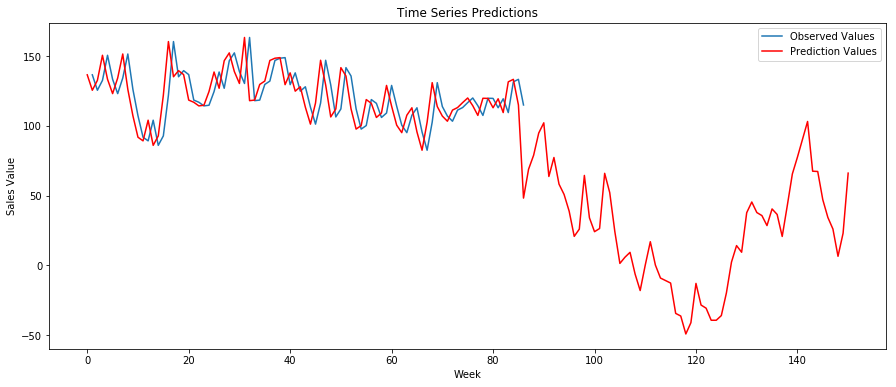

In [22]:
endog1 = test['ventas_valor'] 
exog1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

# Fit the model with fixed lags
mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=test[['products_present_on_store']] ,trend='c', order=((0),1,(0,0,0,0,0,0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi1 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=exog1, typ='linear')
predi1


history1 = [x for x in endog1]
week = 1
for pred in predi1:
	#print('Week %d: %f' % (week, pred))
	history1.append(pred)
	week += 1
    

plt.plot(y)
plt.plot(history1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

**We see all parameters of p,d,q are significant**

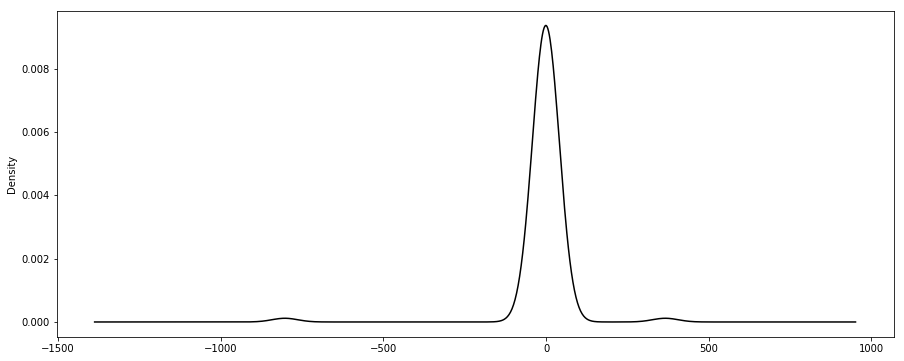

In [32]:
#Check Residulas
res.resid.plot(kind='kde', color='black') #distribution of residuals

The residuals indicate a bell curve distribution with high kurtosis. This indicated outliers which us supported by the time series plot where we experience a dip around week 120.

## NO PROMOTION WITHOUT COMPETITION

Exclude any exogenous variables to capture scenario whithout reinforced competition.

In [34]:
endog2 = test['ventas_valor'] #Use endogenous only
#exog2 = test[['TEMP_MEDIA', 'products_present_on_store']][:65].values #.reshape(65, 1)

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (5,))x(0, 1, (), 52)   Log Likelihood                -132.365
Date:                                Sun, 08 Jul 2018   AIC                            270.729
Time:                                        18:59:09   BIC                            278.092
Sample:                                    01-11-2015   HQIC                           273.692
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1822      1.428      0.128      0.899      -2.617       2.981
ma.

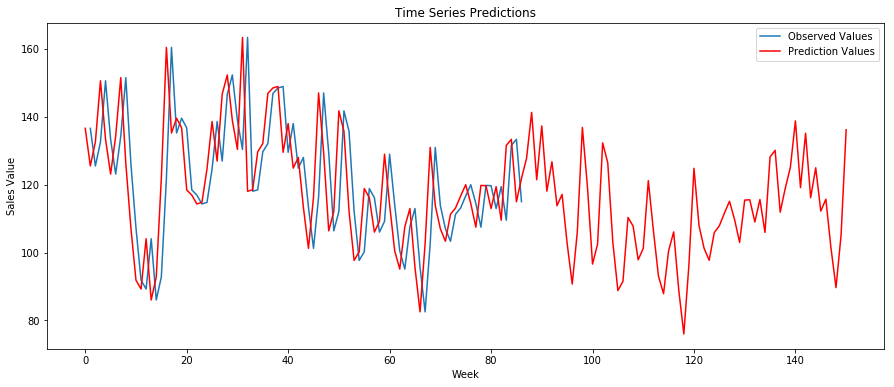

In [35]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=None ,trend='c', order=((0),1,(0,0,0,0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi2 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=None, typ='linear') #only endogenous
predi2

history2 = [x for x in endog2]
week = 1
for pred in predi2:
	#print('Week %d: %f' % (week, pred))
	history2.append(pred)
	week += 1
    

plt.plot(y)
plt.plot(history2, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## Comparison of Competition Effect on Non-Promoted Products of Manufacturer 2

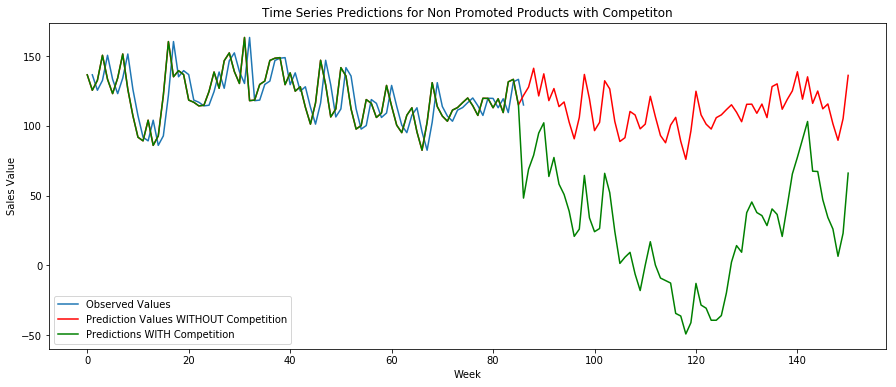

In [36]:
plt.plot(y)
plt.plot(history2, color='red')
plt.plot(history1, color='green')
plt.title('Time Series Predictions for Non Promoted Products with Competiton')
plt.legend(['Observed Values', 'Prediction Values WITHOUT Competition', 'Predictions WITH Competition'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## Year to Year Change of Historical vs. Predicted Data - TIMING OF PROMOTIONAL ACTIVITIES

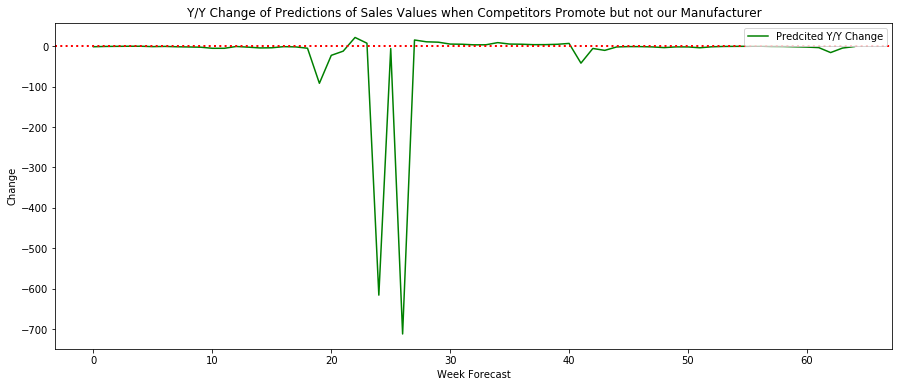

In [40]:
#Get change to the previous year for 
delta = []
len_hist = len(history1)
for i in range(86,int(len_hist)):
    compare_week = i
    delta.append(float(history1[compare_week] - y[compare_week - (len(history1)-86)]) / history1[compare_week])

plt.plot(delta, color='green')
plt.axhline(linewidth=2, color='r' , linestyle= 'dotted')
plt.title('Y/Y Change of Predictions of Sales Values when Competitors Promote but not our Manufacturer' )
plt.legend(['Predcited Y/Y Change'])
plt.xlabel('Week Forecast')
plt.ylabel('Change')
pyplot.show()

### Without Promotion - RISK OF HIGH LOSSES IN +25 WEEKS FROM NOW

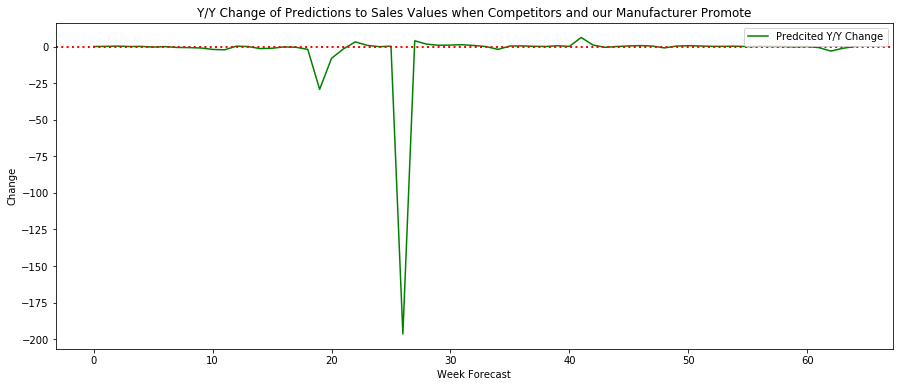

In [41]:
#Get change to the previous year for scnario with promotion
delta = []
len_hist = len(history2)
for i in range(86,int(len_hist)):
    compare_week = i
    delta.append(float(history2[compare_week] - y[compare_week - (len(history2)-86)]) / history1[compare_week])

plt.plot(delta, color='green')
plt.axhline(linewidth=2, color='r' , linestyle= 'dotted')
plt.title('Y/Y Change of Predictions to Sales Values when Competitors and our Manufacturer Promote')
plt.legend(['Predcited Y/Y Change'])
plt.xlabel('Week Forecast')
plt.ylabel('Change')
pyplot.show()

### With Promotion - RISK CAN BE MITIGATED, NOT AVOIDED

We observe a dip in expected revenues between week 20 and 30 from today. Risk of losses can be reduced when our manufacturer goes on promotion and the relative y/y change can be drastically lowered. Recommendatio to go on pomotion between week 20 and 30 to reduce risk of losses.

# HYPERMARKET - PRODUCTS ON PROMOTION

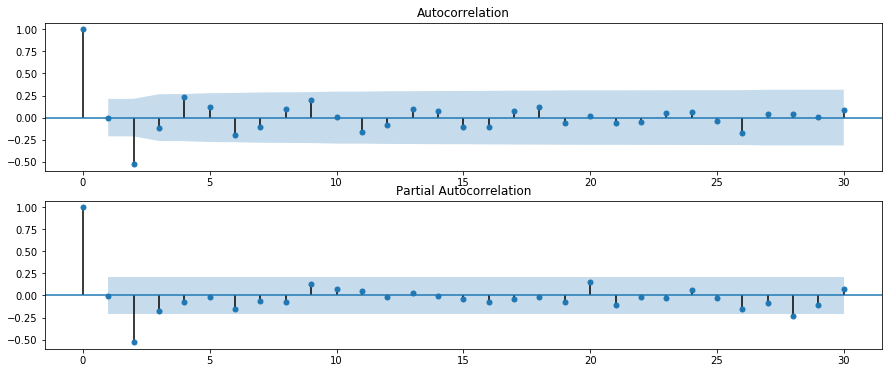

In [43]:
#GET PARAMETERS FOR P,D,Q
XX = promo_hyper.drop(['ventas_valor'], axis=1)
yy = promo_hyper.ventas_valor
zz = yy.diff()
zz.dropna(inplace=True)

#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(zz, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(zz, lags=30, ax=ax2)
plt.show()

In [45]:
#w_milk2_mhp
meta_time_period = pd.read_excel(io='/Users/natasha/Desktop/Term_3/Datathon/Milk_Data/Dictionary.xlsx', sheet_name='Time_Periods')
test1 = pd.merge(promo_hyper.reset_index(), meta_time_period, on='cod_semana', how='right', right_index=True)
test1 = test1.set_index('Date')
pd.to_datetime(test.index, unit='s', yearfirst=True, utc=True)
test1 = test1.dropna()

In [46]:
#exogm2 = w_milk2_mhp[['TEMP_MEDIA', 'PRECIPITACION']].values
#endogm2 = w_milk2_mhp['ventas_valor'].values
endogs1 = test1['ventas_valor'] 
exogs1 = test1[['products_present_on_store']][:65].values #.reshape(65, 1)

In [47]:
test1[test1.columns[1:]].corr()['ventas_valor'][:-1].sort_values(ascending=True).dropna()

products_present_on_store               -0.708107
dummy_BOTTLE                            -0.667627
addtv_present_COCOA_COFFEE              -0.637042
addtive_present_sum                     -0.633088
frmt_present_CRISTAL                    -0.585862
frmt_present_sum                        -0.577139
brnd_present_MAN_2_-BRAND_3             -0.480281
dummy_MAN_2_BRAND_1                     -0.472789
dummy_1500ML                            -0.462331
brnd_present_OTH_MAN_BRAND_3            -0.450819
dummy_ECOLOGIC                          -0.446905
cod_producto                            -0.408119
sgmnt_present_OTHER_ANIMALS_(NO_COWS)   -0.403055
dummy_COCOA_COFFEE                      -0.368993
dummy_OTHERS                            -0.312071
sgmnt_present_ECOLOGIC                  -0.295774
factor_extrapolacion                    -0.294787
dummy_spring                            -0.292583
sgmnt_present_sum                       -0.268114
prods_on_promotions_on_store            -0.250320


## Promo + COMPETITON

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (2,))x(0, 1, (), 52)   Log Likelihood                -151.337
Date:                                Sun, 08 Jul 2018   AIC                            310.675
Time:                                        19:06:15   BIC                            320.492
Sample:                                    01-11-2015   HQIC                           314.626
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     1.9139      2.468     

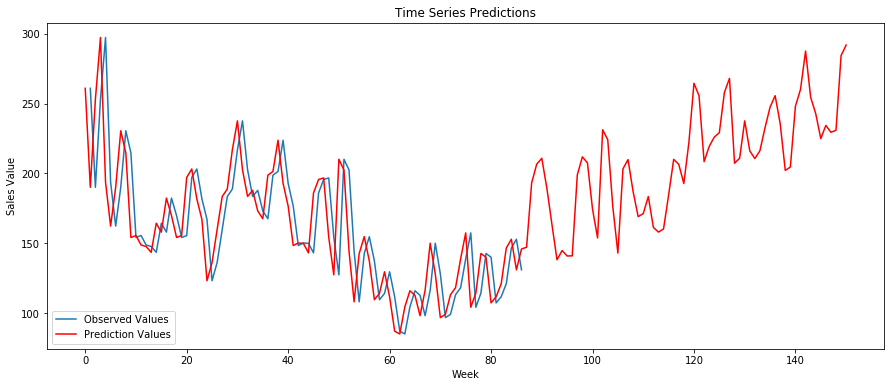

In [48]:
# Fit the model
endogs1 = test1['ventas_valor'] 
exogs1 = test1[['products_present_on_store']][:65].values #.reshape(65, 1)

mod = sm.tsa.statespace.SARIMAX(endog= test1['ventas_valor'] , exog=test1[['products_present_on_store']] ,trend='c', order=((0),1,(0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis1 = res.predict(start=86, end=150, endog= test1['ventas_valor'].values ,exog=exogs1, typ='linear')
predis1

historys1 = [x for x in endogs1]
week = 1
for pred in predis1:
	#print('Week %d: %f' % (week, pred))
	historys1.append(pred)
	week += 1
    

plt.plot(yy)
plt.plot(historys1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## PROMO + NO Competition

In [49]:
endogs2 = test1['ventas_valor'] 
#exogs2 = test1[['TEMP_MEDIA', 'brnd_present_MAN_2_BRAND_1']][:65].values #.reshape(65, 1)

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (2,))x(0, 1, (), 52)   Log Likelihood                -154.216
Date:                                Sun, 08 Jul 2018   AIC                            314.433
Time:                                        19:06:21   BIC                            321.796
Sample:                                    01-11-2015   HQIC                           317.396
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4576      2.761      0.528      0.598      -3.954       6.869
ma.

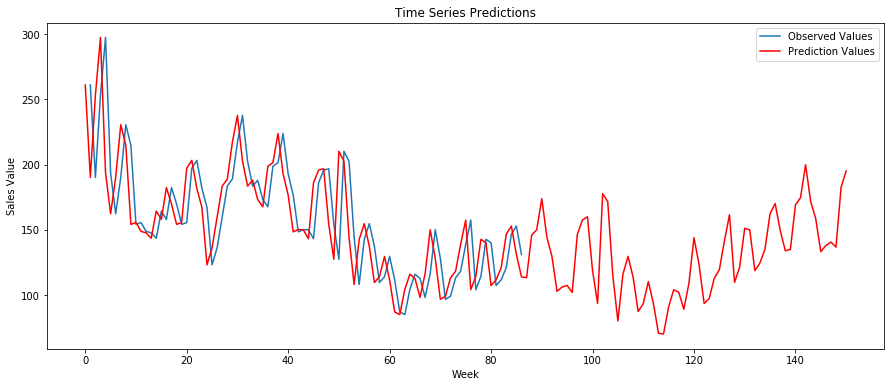

In [50]:
# Fit the model

mod = sm.tsa.statespace.SARIMAX(endog= test1['ventas_valor'] , exog=None ,trend='c', order=((0),1,(0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis2 = res.predict(start=86, end=150, endog= test1['ventas_valor'].values ,exog=None, typ='linear')
predis2

historys2 = [x for x in endogs2]
week = 1
for pred in predis2:
	#print('Week %d: %f' % (week, pred))
	historys2.append(pred)
	week += 1
    

plt.plot(yy)
plt.plot(historys2, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

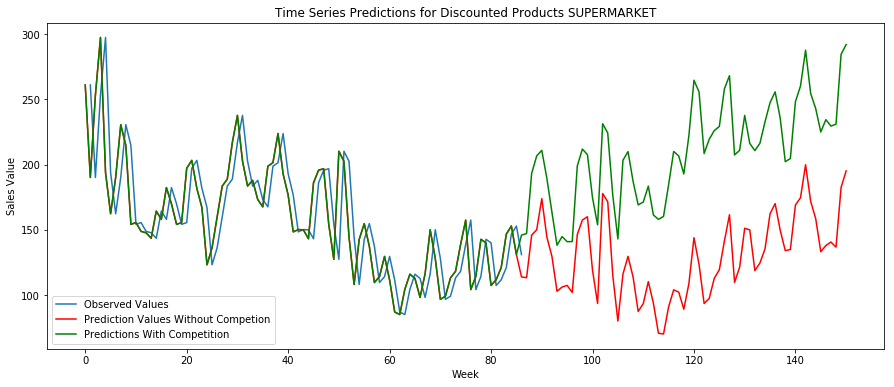

In [51]:
plt.plot(yy)
plt.plot(historys2, color='red')
plt.plot(historys1, color='green')
plt.title('Time Series Predictions for Discounted Products SUPERMARKET')
plt.legend(['Observed Values', 'Prediction Values Without Competion', 'Predictions With Competition'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## TEST - TRAIN SPLIT

predicted=132.956533, expected=98.301648
predicted=90.634011, expected=116.497925
predicted=156.291944, expected=150.144309
predicted=127.836311, expected=128.209677
predicted=107.534899, expected=96.868576
predicted=102.874228, expected=99.215886
predicted=148.032658, expected=113.250000
predicted=119.386967, expected=118.309133
predicted=108.699144, expected=138.916620
predicted=127.589877, expected=157.510133
predicted=92.524216, expected=104.292654
predicted=96.564254, expected=114.424242
predicted=138.694585, expected=142.800546
predicted=166.670459, expected=140.096517
predicted=141.050773, expected=107.438023
predicted=147.326321, expected=111.832428
predicted=155.087319, expected=121.122774
predicted=97.938859, expected=146.670352
predicted=140.364137, expected=152.961394
predicted=139.671533, expected=131.088068
Test MSE: 619.258
Percentual Test MSE: 0.165


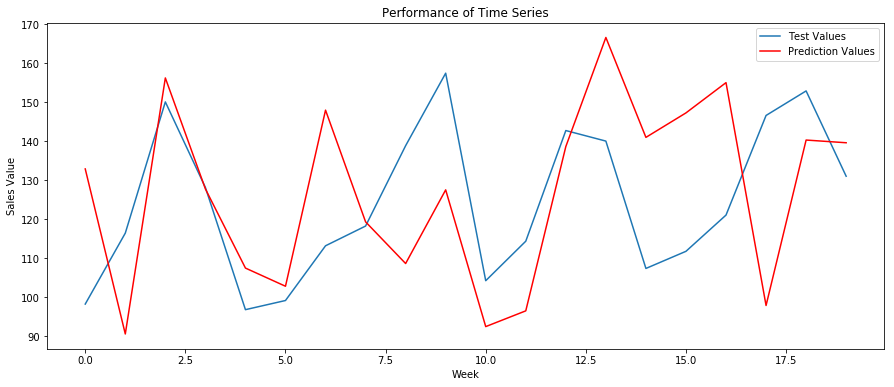

In [64]:
#Resource: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error


series = test1['ventas_valor']
X = series.values
size = int(len(X) * 0.77) #split into 2/3 train 1/3 test
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = sm.tsa.statespace.SARIMAX(history, exog= None, order=((0,1),1,(0,0,1)), seasonal_order=(0,1,0,52)) #reduced the MSE but does not account for stationarity
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
mse = sum(abs(test-predictions))/sum(test)
print('Percentual Test MSE: %.3f' % mse.mean())

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
plt.title('Performance of Time Series')
plt.legend(['Test Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

** MSE is satisfactory - for better test train performance more datapoints are needed. Using SARIMA with seasonal differencing reduced the number of oberservations further.**

## ORIGINAL SCALE ACF, PACF

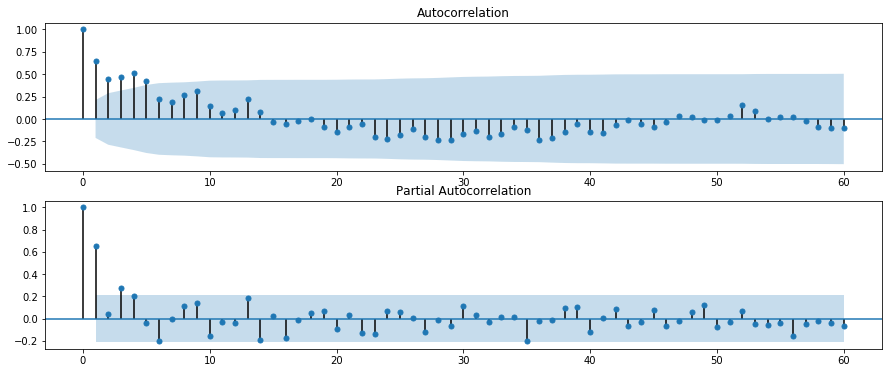

In [68]:
target = milk_weekly.ventas_valor
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(target, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(target, lags=60, ax=ax2)
plt.show()

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                   86
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 52)   Log Likelihood                 -94.468
Date:                            Sun, 08 Jul 2018   AIC                            194.935
Time:                                    19:13:03   BIC                            202.298
Sample:                                         0   HQIC                           197.898
                                             - 86                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7124      0.774      0.921      0.357      -0.804       2.229
ar.L1         -0.6421      0.146   

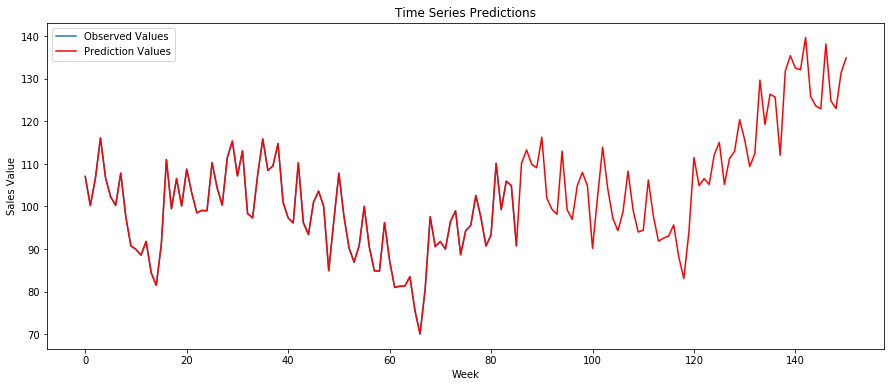

In [69]:
# Fit the model
target = milk_weekly.ventas_valor.values
mod = sm.tsa.statespace.SARIMAX(target, trend='c', order=(1,1,(0)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi = res.predict(start=86, end=150, exog=None, dynamic=False)
predi

history = [x for x in target]
week = 1
for pred in predi:
	#print('Week %d: %f' % (week, pred))
	history.append(pred)
	week += 1
    

plt.plot(target)
plt.plot(history, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

### COMPARISON OF COMPETITION EFFECT ON PROMOTED PRODUCTS FOR MANUFACTURER 2

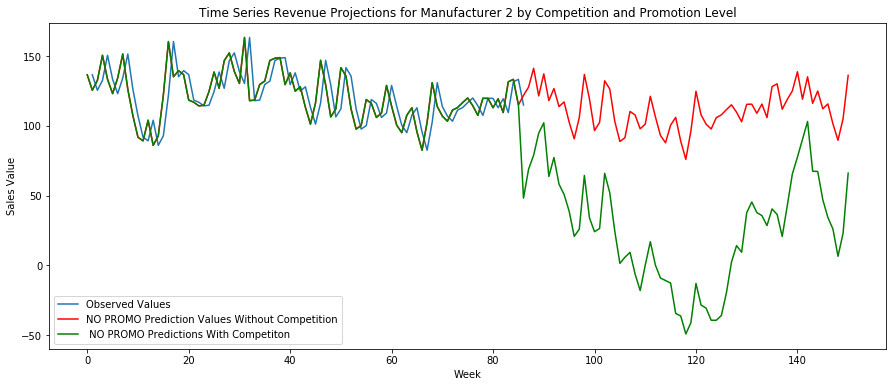

In [70]:
plt.plot(y)
plt.plot(history2, color='red')
plt.plot(history1, color='green')
#plt.plot(historys2, color='pink')
#plt.plot(historys1, color='violet')
#plt.plot(history, color='black')
plt.title('Time Series Revenue Projections for Manufacturer 2 by Competition and Promotion Level')
plt.legend(['Observed Values', 'NO PROMO Prediction Values Without Competition', ' NO PROMO Predictions With Competiton'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
plt.savefig('Time_Series_Manu1.png', dpi=700)
pyplot.show()

# SUPERMARKET 

In [75]:
#NO PROMOTIONS
milk2_msnp = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 (milk['dummy_channel_hypermarket']!=1) & (milk['dummy_Promo_descuento']!=1)]
no_promo_super = milk2_msnp.groupby('cod_semana').mean()


#PROMOTIONS
milk2_msp = milk[(milk['dummy_MANUFACTURER_2']==1) & 
                 (milk['dummy_channel_hypermarket']!=1) & (milk['dummy_Promo_descuento']==1)]
promo_super = milk2_msp.groupby('cod_semana').mean()

## STATIONARITY

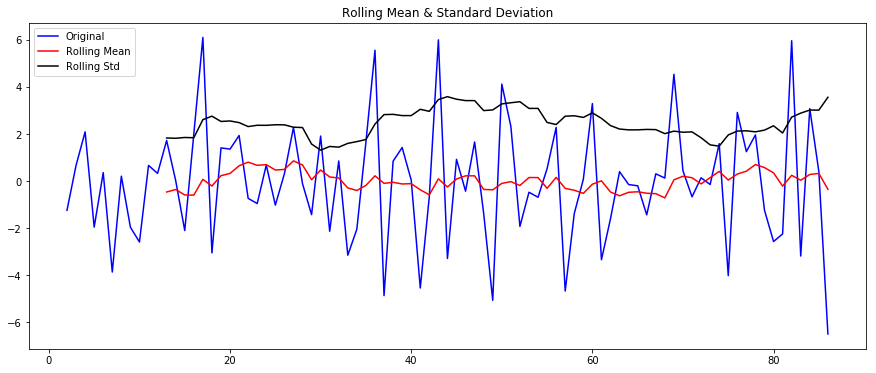

Results of Dickey-Fuller Test:
Test Statistic                -7.462783e+00
p-value                        5.299810e-11
#Lags Used                     2.000000e+00
Number of Observations Used    8.200000e+01
Critical Value (1%)           -3.512738e+00
Critical Value (5%)           -2.897490e+00
Critical Value (10%)          -2.585949e+00
dtype: float64


In [327]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller

y = no_promo_super.ventas_valor
z = y.diff()
z.dropna(inplace=True)

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series.rolling(timeseries, window=12).mean()
    rolstd = pd.Series.rolling(timeseries, window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)#On transformed data
test_stationarity(z) #one transformation is enough

## Differenced PACF ACF

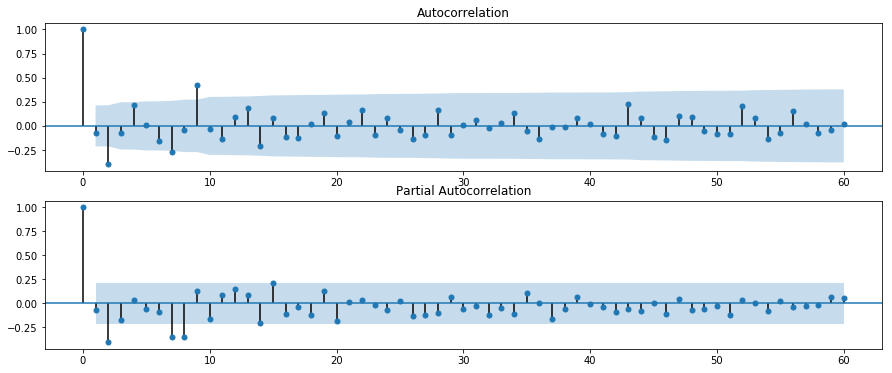

In [437]:
#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(z, lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(z, lags=60, ax=ax2)
plt.show()

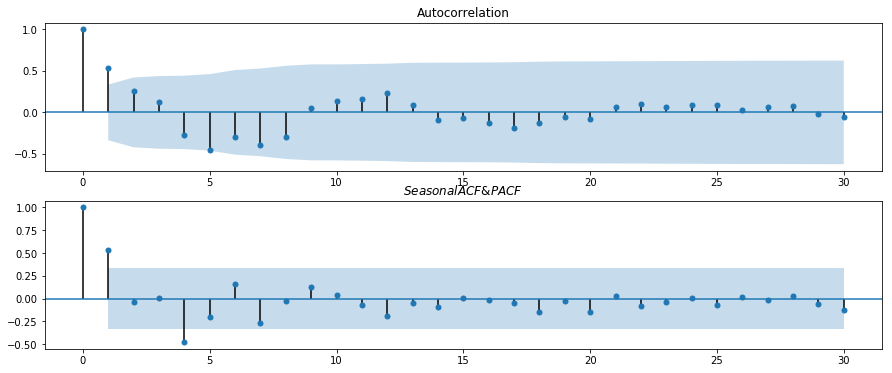

In [438]:
#TAKE THE SEASONAL DIFFERENCE
from matplotlib import pyplot

X = y.values
diff = list()
weeks_in_year = 52
for i in range(weeks_in_year, len(X)):
	value = X[i] - X[i - weeks_in_year]
	diff.append(value)
#pyplot.plot(diff)
#pyplot.show()


#Inbuilt plotting available in statsmodels
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(diff, lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(diff, lags=30, ax=ax2)
plt.title('$Seasonal ACF & PACF$')
plt.show()

In [77]:
test = pd.merge(no_promo_super.reset_index(), meta_time_period, on='cod_semana', how='right', right_index=True)
test = test.set_index('Date')
pd.to_datetime(test.index, unit='s', yearfirst=True, utc=True)
test = test1.dropna()

#Exo + Endo
endogs1 = test['ventas_valor'] 
exogs1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

## NO PROMOTIONS + COMPETITION

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX((2,), 1, 0)x((), 1, 0, 52)   Log Likelihood                -151.067
Date:                                Sun, 08 Jul 2018   AIC                            310.134
Time:                                        19:16:04   BIC                            319.951
Sample:                                    01-11-2015   HQIC                           314.085
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     3.5342      4.645     

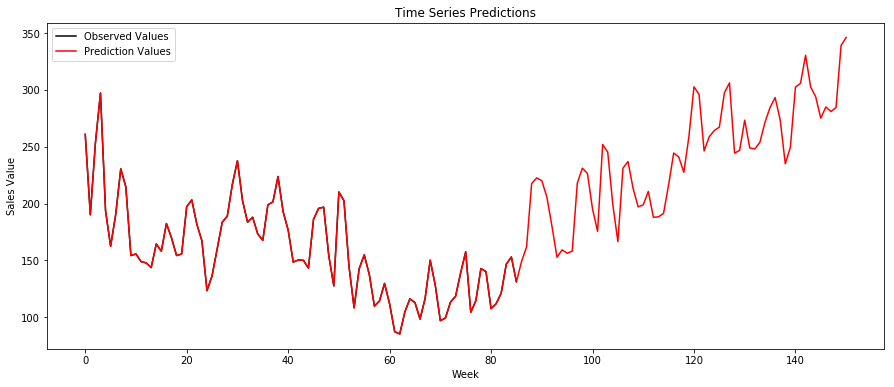

In [78]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=test[['products_present_on_store']] ,trend='c', order=((0,1),1,(0)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis1 = res.predict(start=86, end=150, endog= test['ventas_valor'].values, exog=exogs1, typ='linear')
predis1

historys1 = [x for x in endogs1]
week = 1
for pred in predis1:
	#print('Week %d: %f' % (week, pred))
	historys1.append(pred)
	week += 1
    

plt.plot(test['ventas_valor'].values, color='black')
plt.plot(historys1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## NO PROMOTIONS + NO COMPETITION

                                 Statespace Model Results                                 
Dep. Variable:                       ventas_valor   No. Observations:                   86
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 52)   Log Likelihood                -159.286
Date:                            Sun, 08 Jul 2018   AIC                            324.573
Time:                                    19:21:58   BIC                            331.936
Sample:                                01-11-2015   HQIC                           327.536
                                     - 08-28-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -25.7510     11.471     -2.245      0.025     -48.234      -3.268
ar.L1          0.6050      0.131   

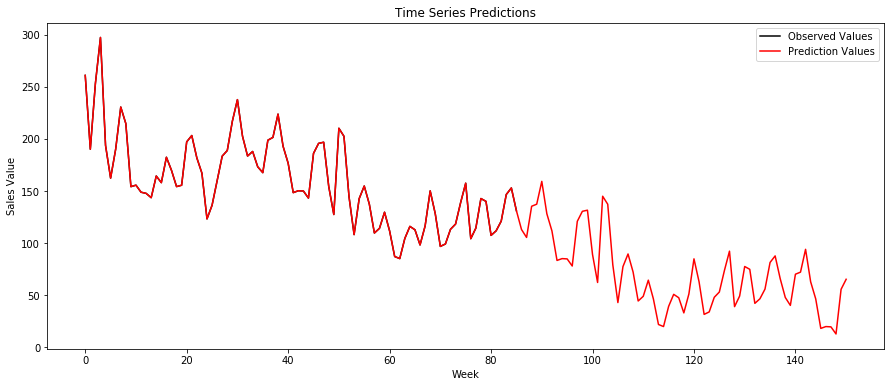

In [101]:
# Fit the model
endogs2 = yy

mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=None ,trend='c', order=((1),0,(0)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis2 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=None, typ='linear')
predis2

historys2 = [x for x in endogs2]
week = 1
for pred in predis2:
	#print('Week %d: %f' % (week, pred))
	historys2.append(pred)
	week += 1
    

plt.plot(test['ventas_valor'].values, color='black')
plt.plot(historys2, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

## PROMOTIONS + COMPETITON

In [154]:
#meta_time_period = pd.read_excel(io='Dictionary.xlsx', sheet_name='Time_Periods')
test = pd.merge(promo_super.reset_index(), meta_time_period, on='cod_semana', how='right', right_index=True)
test = test.set_index('Date')
pd.to_datetime(test.index, unit='s', yearfirst=True, utc=True)
test = test1.dropna()

#Exo + Endo
endog1 = test['ventas_valor'] 
exog1 = test.drop(['ventas_valor'], axis = 1).values #reshape(65, 1)

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (2,))x(0, 1, (), 52)   Log Likelihood                -151.337
Date:                                Sun, 08 Jul 2018   AIC                            310.675
Time:                                        20:11:13   BIC                            320.492
Sample:                                    01-11-2015   HQIC                           314.626
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     1.9139      2.468     

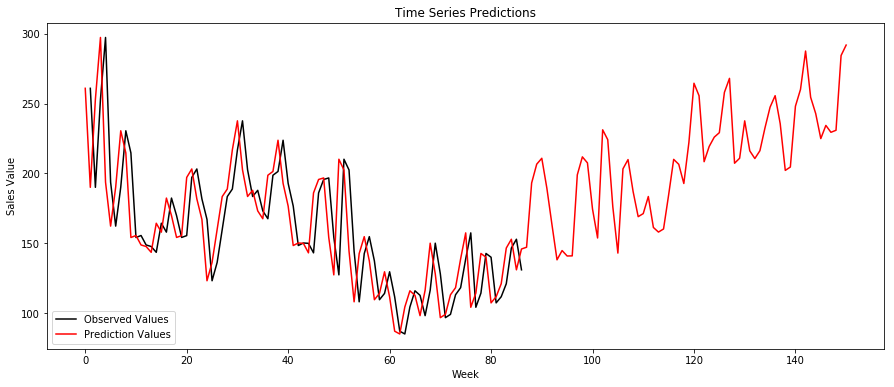

In [153]:
endog1 = test['ventas_valor'] 
exog1 = test[['products_present_on_store']][:65].values #.reshape(65, 1)

# Fit the model with fixed lags
mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=test[['products_present_on_store']] ,trend='c', order=((0),1,(0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predi1 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=exog1, typ='linear')
predi1


history1 = [x for x in endog1]
week = 1
for pred in predi1:
	#print('Week %d: %f' % (week, pred))
	history1.append(pred)
	week += 1
    

plt.plot(yy, color='black')
plt.plot(history1, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

Sales expected to rise when we go on promotions in Supermarket regardless of the competition level.

## PROMOTIONS + NO COMPETITON

                                   Statespace Model Results                                   
Dep. Variable:                           ventas_valor   No. Observations:                   86
Model:             SARIMAX(0, 1, (2,))x(0, 1, (), 52)   Log Likelihood                -154.216
Date:                                Sun, 08 Jul 2018   AIC                            314.433
Time:                                        19:29:49   BIC                            321.796
Sample:                                    01-11-2015   HQIC                           317.396
                                         - 08-28-2016                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4576      2.761      0.528      0.598      -3.954       6.869
ma.

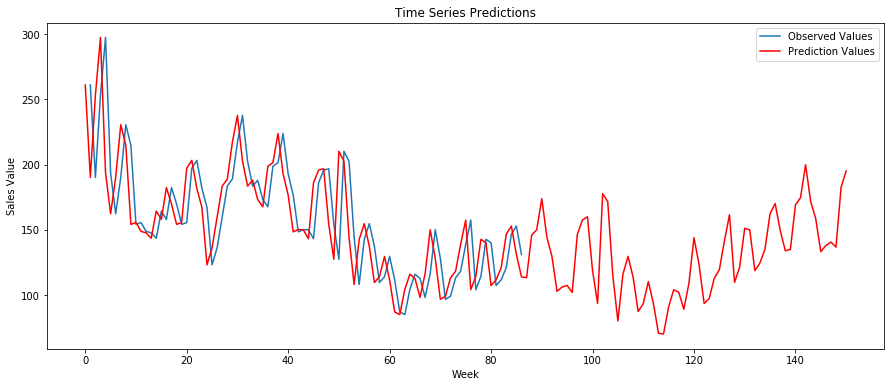

In [117]:
# Fit the model
endogs1 = test['ventas_valor'] 
#exogs1 = test1[['products_present_on_store']][:65].values #.reshape(65, 1)

mod = sm.tsa.statespace.SARIMAX(endog= test['ventas_valor'] , exog=None ,trend='c', order=((0),1,(0,1)), seasonal_order=(0,1,0,52))
res = mod.fit(disp=False)
print(res.summary())

predis1 = res.predict(start=86, end=150, endog= test['ventas_valor'].values ,exog=None, typ='linear')
predis1

history2 = [x for x in endogs1]
week = 1
for pred in predis1:
	#print('Week %d: %f' % (week, pred))
	history2.append(pred)
	week += 1
    

plt.plot(yy)
plt.plot(history2, color='red')
plt.title('Time Series Predictions')
plt.legend(['Observed Values', 'Prediction Values'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
pyplot.show()

### Year to Year Change and Timing of Promotional Activities 

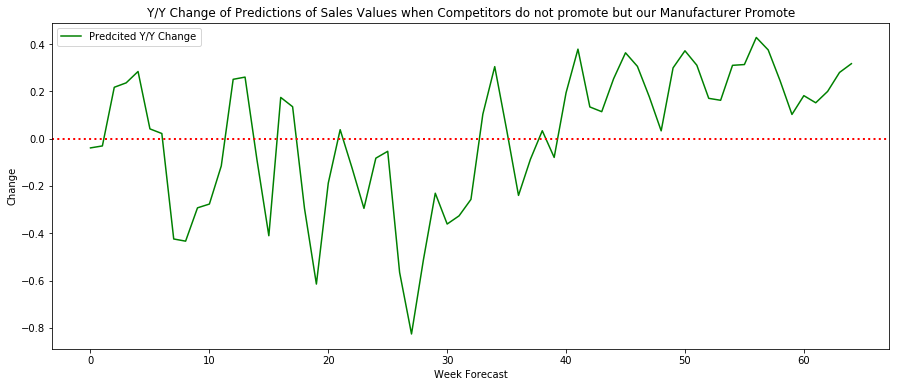

In [127]:
#Get change to the previous year for 
delta = []
len_hist = len(history2)
for i in range(86,int(len_hist)):
    compare_week = i
    delta.append(float(history2[compare_week] - y[compare_week - (len(history2)-86)]) / history2[compare_week])

plt.plot(delta, color='green')
plt.axhline(linewidth=2, color='r' , linestyle= 'dotted')
plt.title('Y/Y Change of Predictions of Sales Values when Competitors do not promote but our Manufacturer Promote' )
plt.legend(['Predcited Y/Y Change'])
plt.xlabel('Week Forecast')
plt.ylabel('Change')
pyplot.show()

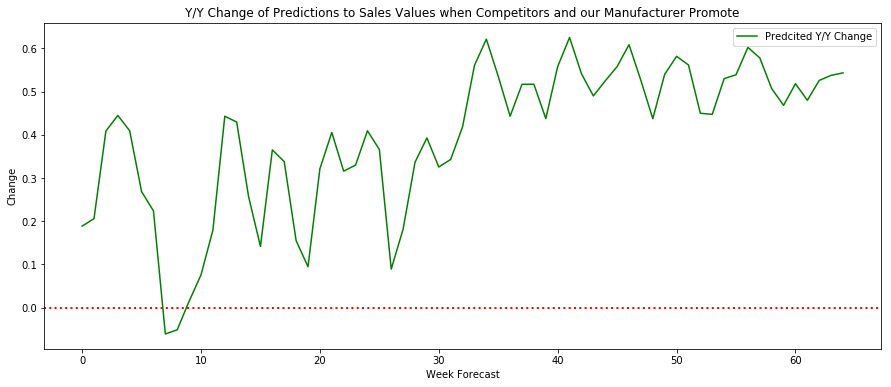

In [126]:
#Get change to the previous year for scnario with promotion
delta = []
len_hist = len(history1)
for i in range(86,int(len_hist)):
    compare_week = i
    delta.append(float(history1[compare_week] - y[compare_week - (len(history1)-86)]) / history1[compare_week])

plt.plot(delta, color='green')
plt.axhline(linewidth=2, color='r' , linestyle= 'dotted')
plt.title('Y/Y Change of Predictions to Sales Values when Competitors and our Manufacturer Promote')
plt.legend(['Predcited Y/Y Change'])
plt.xlabel('Week Forecast')
plt.ylabel('Change')
pyplot.show()

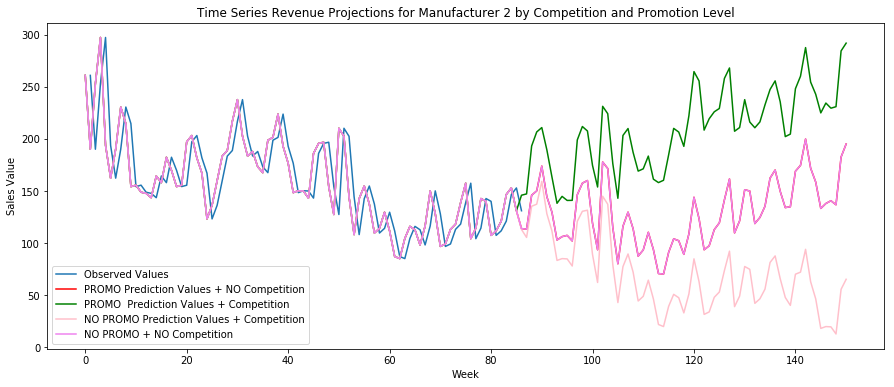

In [122]:
plt.plot(yy)
plt.plot(history2, color='red')
plt.plot(history1, color='green')
plt.plot(historys2, color='pink')
plt.plot(historys1, color='violet')
plt.title('Time Series Revenue Projections for Manufacturer 2 by Competition and Promotion Level')
plt.legend(['Observed Values', 'PROMO Prediction Values + NO Competition', 'PROMO  Prediction Values + Competition', 'NO PROMO Prediction Values + Competition', 'NO PROMO + NO Competition'])
plt.xlabel('Week')
plt.ylabel('Sales Value')
#plt.savefig('Time_Series_Manu1_Supermarket.png', dpi=700)
pyplot.show()

# Recommendations:

We see that for both scenarios, super and hypermarket promotion and competition activicties could have an effect on expected revenues. 

- In hypermarkets, the revenues are expected to decline when competitors go on promotions while our manufacturer does not. Hence, we found that the products of our manufacturer should be discounted especially around week 105 to mitigate protential tremendous revenue losses. 

- In supermarkets, promotions of our manufacturer indicate a positive effect in overall sales. We recommend to go on promotion regardless of the competitors activites. This holds especially true from week 100 on. Customers in supermarkets tend to buy more of our milk when we go on promotion, regardless of what the competition does. Potential damaging branding effects need to be assessed are are not captured in this analysis. Promotion should especially takle place from week 86 until week 125.